In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
#!pip install datasets
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data study

In [3]:
# import the Sentiment Analysis for Financial News DataSet: FinancialPhraseBank (Available on Hugging Face)

# https://huggingface.co/datasets/financial_phrasebank
# 0 is negative
# 1 is positive
# 2 is neutral

dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset["train"])

# Print the first few rows to understand the structure
print(df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      2
2  In the third quarter of 2010 , net sales incre...      2
3  Operating profit rose to EUR 13.1 mn from EUR ...      2
4  Operating profit totalled EUR 21.1 mn , up fro...      2


Text(0.5, 1.0, 'Distribution of the data among the labels')

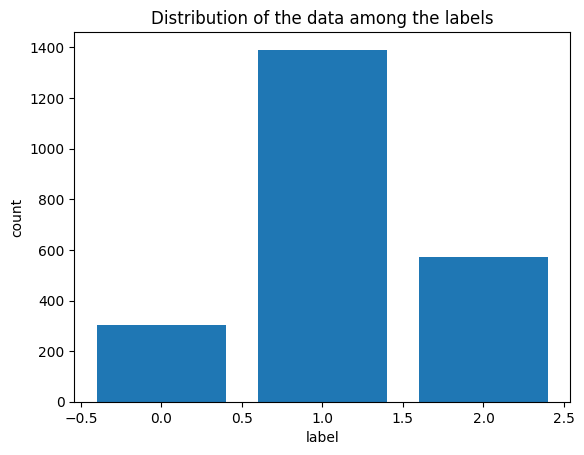

In [4]:
df = pd.DataFrame(dataset["train"])

df_distrib = df["label"].value_counts()
plt.bar(df_distrib.index, df_distrib.values)
plt.xlabel("label")
plt.ylabel("count")
plt.title("Distribution of the data among the labels")

(-0.5, 399.5, 199.5, -0.5)

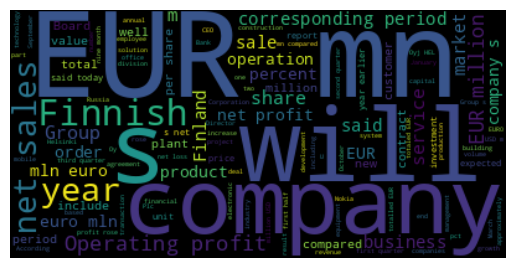

In [5]:
from wordcloud import WordCloud

text = " ".join(df["sentence"])

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

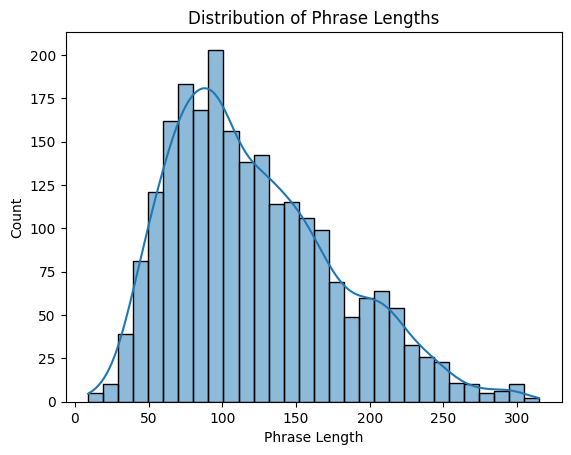

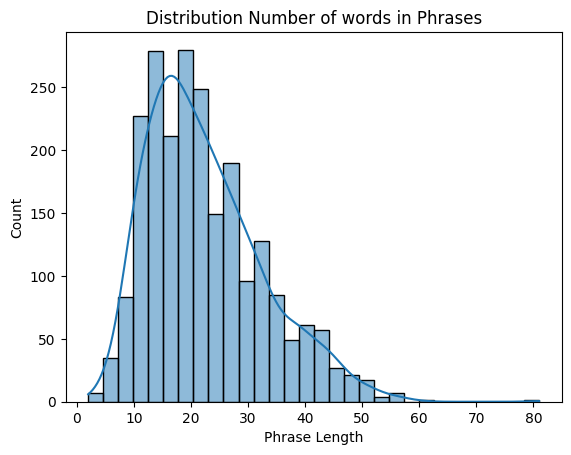

In [6]:
import seaborn as sns

phrase_length = pd.DataFrame(data=dataset["train"]).apply(lambda x : len(x["sentence"]), axis=1)
sns.histplot(phrase_length, bins=30, kde=True)
plt.title('Distribution of Phrase Lengths')
plt.xlabel('Phrase Length')
plt.show()

number_words = pd.DataFrame(data=dataset["train"]).apply(lambda x : len(x["sentence"].split(" ")), axis=1)
sns.histplot(number_words, bins=30, kde=True)
plt.title('Distribution Number of words in Phrases')
plt.xlabel('Phrase Length')
plt.show()

# Preprocess the data

In [7]:
# Define stopwords
en_stopwords = set(stopwords.words("english"))

# Define preprocessing function
def preprocessing(sentence):
    sentence = sentence.lower()  # Remove caps
    sentence = re.sub(r"[^a-z\s]", "", sentence)  # Remove everything that is not a letter or a space
    sentence = word_tokenize(sentence)  # Tokenize
    sentence = [word for word in sentence if word not in en_stopwords]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    sentence = [lemmatizer.lemmatize(word) for word in sentence]  # Lemmatize
    return " ".join(sentence)

# Preprocess the sentences for the training and validation sets
df["sentence_preprocessed"] = df["sentence"].apply(preprocessing)

print(df.head())

                                            sentence  label  \
0  According to Gran , the company has no plans t...      1   
1  For the last quarter of 2010 , Componenta 's n...      2   
2  In the third quarter of 2010 , net sales incre...      2   
3  Operating profit rose to EUR 13.1 mn from EUR ...      2   
4  Operating profit totalled EUR 21.1 mn , up fro...      2   

                               sentence_preprocessed  
0  according gran company plan move production ru...  
1  last quarter componenta net sale doubled eurm ...  
2  third quarter net sale increased eur mn operat...  
3  operating profit rose eur mn eur mn correspond...  
4  operating profit totalled eur mn eur mn repres...  


In [8]:
# Define tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define tokenization function
def tokenize(batch):
    return tokenizer(batch['sentence_preprocessed'], padding='max_length', truncation=True, max_length=512)

# Tokenize the dataset
preprocessed_dataset = Dataset.from_pandas(df[['sentence_preprocessed', 'label']])
preprocessed_dataset = preprocessed_dataset.map(tokenize, batched=True)

# Add labels to the dataset and set format for PyTorch
preprocessed_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Split the dataset into training, validation, and testing datasets
length = len(preprocessed_dataset)
indices = list(range(length))
train_val_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_val_dataset = preprocessed_dataset.select(train_val_indices)
test_dataset = df.loc[test_indices]  # Non-preprocessed test set in DataFrame format

# Further split the train_val_dataset into training and validation datasets
train_indices, val_indices = train_test_split(
    list(range(len(train_val_dataset))), test_size=0.2, random_state=42
)

train_dataset = train_val_dataset.select(train_indices)
val_dataset = train_val_dataset.select(val_indices)

# Print data splits
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Number of training samples: 1448
Number of validation samples: 363
Number of test samples: 453


# Bert fine-tuning

In [11]:
# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save at the end of each epoch
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

# Evaluate our fine-tuning

In [ ]:
# Evaluate the model on the training set
training_accuracy = trainer.evaluate(train_dataset)
print(f"Training accuracy: {training_accuracy['eval_accuracy']}")

# Evaluate the model on the validation set
validation_accuracy = trainer.evaluate(val_dataset)
print(f"Validation accuracy: {validation_accuracy['eval_accuracy']}")

# Define tokenization function for non-preprocessed test set
def tokenize_no_preprocessing(batch):
    return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=512)

# Convert non-preprocessed test set to Hugging Face dataset
test_dataset_hf = Dataset.from_pandas(test_dataset[['sentence', 'label']])

# Tokenize the non-preprocessed test set
test_dataset_hf = test_dataset_hf.map(tokenize_no_preprocessing, batched=True)
test_dataset_hf.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Evaluate the model on the non-preprocessed test set
evaluation_results = trainer.evaluate(test_dataset_hf)
print(f"Accuracy on the test set: {evaluation_results['eval_accuracy']}")

# Print evaluation results
print(evaluation_results)